Project 2: Ames Housing Data and Kaggle Challenge

Problem Statement:
    To create a regression model to predict the sales price for each house

In [1]:
import random as rand
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import imp
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, PolynomialFeatures 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn import metrics
from sklearn import feature_extraction 
from sklearn.metrics import r2_score, mean_squared_error

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
ames_train = pd.read_csv('datasets/train.csv')

In [3]:
def explore(df):
    print(df.shape)
    print("")
    print(df.head())
    print("")
    print(df.dtypes)
    print("")
    print(df.isnull().sum())
    print("")
    print(df.describe())
    
explore(ames_train)

(2051, 81)

    Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0  109  533352170           60        RL           NaN     13517   Pave   NaN   
1  544  531379050           60        RL          43.0     11492   Pave   NaN   
2  153  535304180           20        RL          68.0      7922   Pave   NaN   
3  318  916386060           60        RL          73.0      9802   Pave   NaN   
4  255  906425045           50        RL          82.0     14235   Pave   NaN   

  Lot Shape Land Contour Utilities Lot Config Land Slope Neighborhood  \
0       IR1          Lvl    AllPub    CulDSac        Gtl       Sawyer   
1       IR1          Lvl    AllPub    CulDSac        Gtl      SawyerW   
2       Reg          Lvl    AllPub     Inside        Gtl        NAmes   
3       Reg          Lvl    AllPub     Inside        Gtl       Timber   
4       IR1          Lvl    AllPub     Inside        Gtl      SawyerW   

  Condition 1 Condition 2 Bldg Type House Style  Overall Qual 

In [4]:
#Replacing the np.nan cells to their respective column values

ames_train['Lot Frontage'] = ames_train['Lot Frontage'].replace({np.nan:0})
#Changing to NA for no alley access
ames_train['Alley'] = ames_train['Alley'].replace({np.nan:'NA'})

#both 'Mas Vnr Type' and 'Mas Vnr Area' are 22 entries that are tied to each other
ames_train['Mas Vnr Type'] = ames_train['Mas Vnr Type'].replace({np.nan:'None'})
ames_train['Mas Vnr Area'] = ames_train['Mas Vnr Area'].replace({np.nan:0})

#55 entries without basement
ames_train['Bsmt Qual'] = ames_train['Bsmt Qual'].replace({np.nan:'NA'})
ames_train['Bsmt Cond'] = ames_train['Bsmt Cond'].replace({np.nan:'NA'})

#These three cells has a basement but their exposure is unknown
ames_train.iloc[1456, ames_train.columns.get_loc('Bsmt Exposure')] = 'No'
ames_train.iloc[1547, ames_train.columns.get_loc('Bsmt Exposure')] = 'No'
ames_train.iloc[1997, ames_train.columns.get_loc('Bsmt Exposure')] = 'No'

#entries without basement
ames_train['Bsmt Exposure'] = ames_train['Bsmt Exposure'].replace({np.nan:'NA'})
ames_train['BsmtFin Type 1'] = ames_train['BsmtFin Type 1'].replace({np.nan:'NA'})
ames_train['BsmtFin SF 1'] = ames_train['BsmtFin SF 1'].replace({np.nan:0})
ames_train['BsmtFin Type 2'] = ames_train['BsmtFin Type 2'].replace({np.nan:'NA'})
ames_train['BsmtFin SF 2'] = ames_train['BsmtFin SF 2'].replace({np.nan:0})
ames_train['Bsmt Unf SF'] = ames_train['Bsmt Unf SF'].replace({np.nan:0})
ames_train['Total Bsmt SF'] = ames_train['Total Bsmt SF'].replace({np.nan:0})
ames_train['Bsmt Full Bath'] = ames_train['Bsmt Full Bath'].replace({np.nan:0})
ames_train['Bsmt Half Bath'] = ames_train['Bsmt Half Bath'].replace({np.nan:0})

#All fireplace Qu with np.nan is does not have a fireplace.
ames_train['Fireplace Qu'] = ames_train['Fireplace Qu'].replace({np.nan:'NA'})

#All except for row1712, does not have a garage. 
ames_train['Garage Type'] = ames_train['Garage Type'].replace({np.nan:'NA'})
ames_train.iloc[1712, ames_train.columns.get_loc('Garage Yr Blt')] = ames_train.iloc[1712, ames_train.columns.get_loc('Year Remod/Add')]
ames_train['Garage Yr Blt'] = ames_train['Garage Yr Blt'].replace({np.nan:0})
ames_train['Garage Finish'] = ames_train['Garage Finish'].replace({np.nan:'NA'})
ames_train['Garage Cars'] = ames_train['Garage Cars'].replace({np.nan:0})
ames_train['Garage Area'] = ames_train['Garage Area'].replace({np.nan:0})
ames_train['Garage Qual'] = ames_train['Garage Qual'].replace({np.nan:'NA'})
ames_train['Garage Cond'] = ames_train['Garage Cond'].replace({np.nan:'NA'})


#All Pool QC with np.nan has pool area of 0
ames_train['Pool QC'] = ames_train['Pool QC'].replace({np.nan:'NA'})
ames_train['Fence'] = ames_train['Fence'].replace({np.nan:'NA'})
ames_train['Misc Feature'] = ames_train['Misc Feature'].replace({np.nan:'NA'})

In [5]:
#choosing only 10 features in this model:

ames_train=ames_train[['MS SubClass',
                       'MS Zoning',
                       'Lot Area',
                       'Utilities',
                       'Neighborhood',
                      'Overall Qual',
                      'Overall Cond',
                      'Year Built',
                      'Gr Liv Area',
                      'Garage Qual',
                      'SalePrice']]

In [6]:
ames_train.head(2)

,MS SubClass,MS Zoning,Lot Area,Utilities,Neighborhood,Overall Qual,Overall Cond,Year Built,Gr Liv Area,Garage Qual,SalePrice
0,60,RL,13517,AllPub,Sawyer,6,8,1976,1479,TA,130500
1,60,RL,11492,AllPub,SawyerW,7,5,1996,2122,TA,220000


In [7]:
#encoding each ordinal categorical features, full glossary in readme
from sklearn import preprocessing
le = preprocessing.LabelEncoder()


def transform(col):
    for i in col:
        le.fit(ames_train[i])
        list(le.classes_)
        ames_train[i] = le.transform(ames_train[i])

columns = ['Utilities',
           'Garage Qual']

transform(columns)

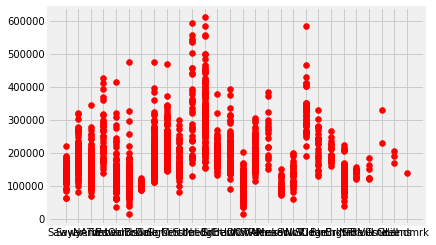

In [8]:
plt.scatter(ames_train['Neighborhood'],ames_train['SalePrice'],color='red')

In [9]:
column2= ['MS SubClass',
         'MS Zoning',
         'Neighborhood']

ames_train = pd.get_dummies(data = ames_train, prefix=column2, columns = column2, drop_first=True)

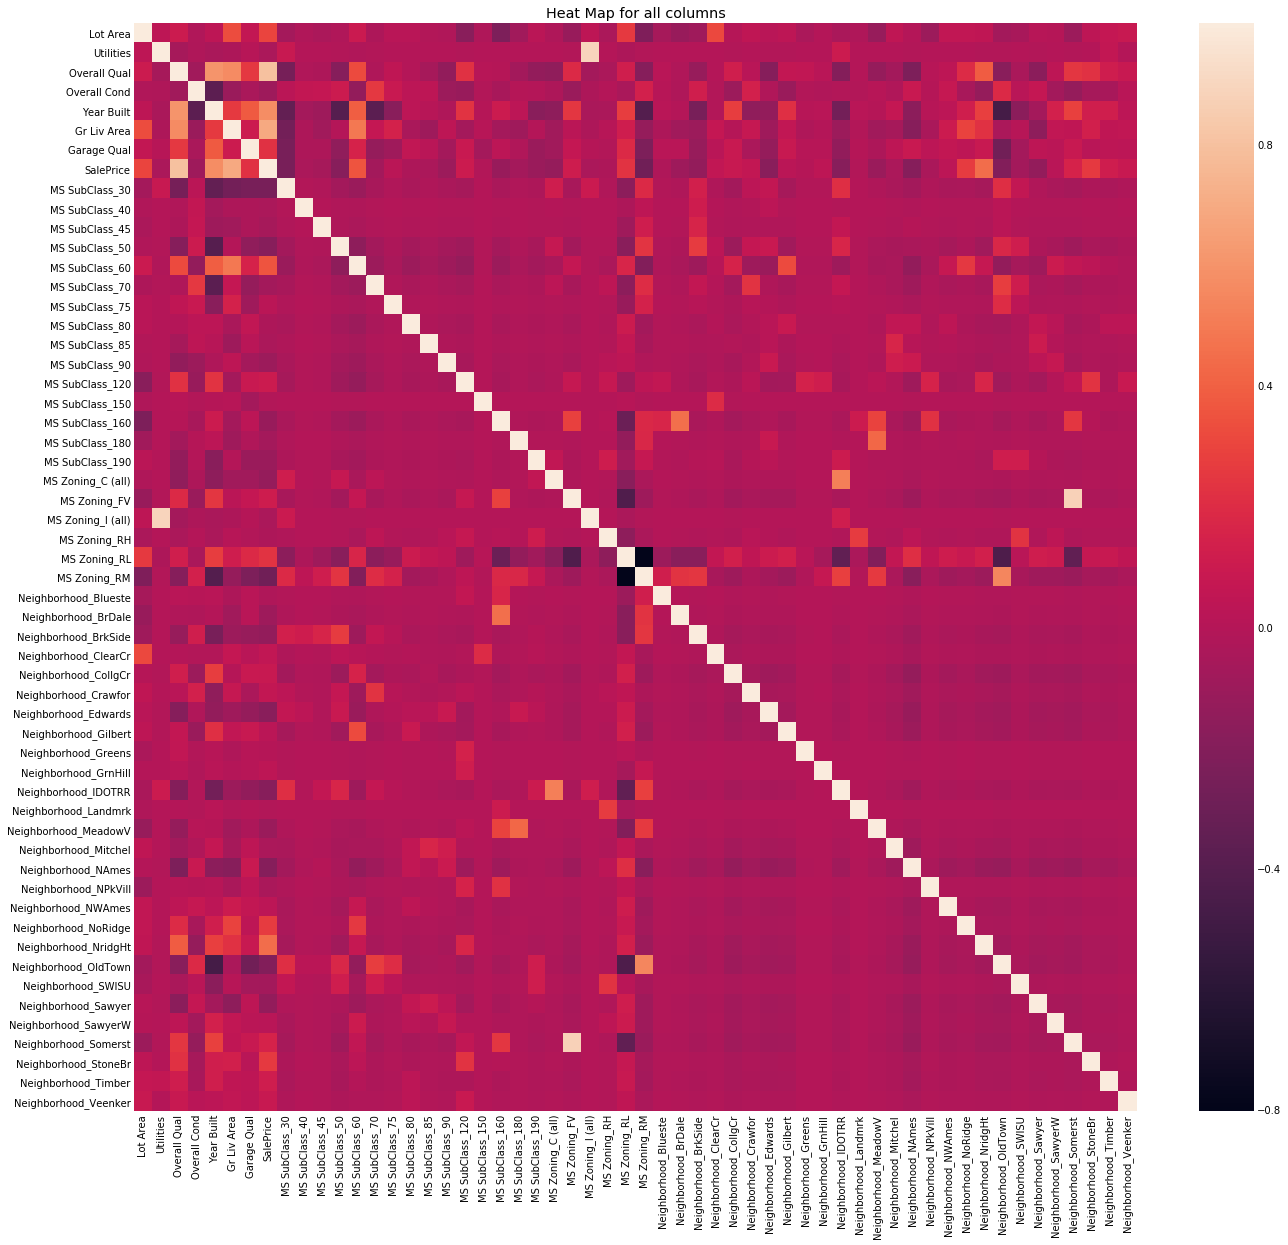

In [10]:
fig, ax = plt.subplots(figsize=(20,20)) 
ax.set_title('Heat Map for all columns')
sns.heatmap(ames_train.corr(), ax = ax, annot=False, annot_kws={"size": 20})

In [11]:
ames_train[ames_train.columns[1:]].corr()['SalePrice'][:].sort_values(ascending=False)

SalePrice               1.000000
Overall Qual            0.800207
Gr Liv Area             0.697038
Year Built              0.571849
Neighborhood_NridgHt    0.448647
MS SubClass_60          0.355421
Neighborhood_NoRidge    0.263395
Neighborhood_StoneBr    0.256977
MS Zoning_RL            0.231468
Garage Qual             0.219385
Neighborhood_Somerst    0.150078
Neighborhood_Timber     0.116400
MS Zoning_FV            0.106695
MS SubClass_120         0.100434
Neighborhood_Veenker    0.083186
Neighborhood_CollgCr    0.082309
Neighborhood_Crawfor    0.058386
Neighborhood_ClearCr    0.052503
Neighborhood_GrnHill    0.038848
Neighborhood_NWAmes     0.034926
MS SubClass_75          0.026191
Neighborhood_Gilbert    0.023974
Neighborhood_SawyerW    0.016708
Neighborhood_Greens     0.003476
MS SubClass_150        -0.009217
Neighborhood_Landmrk   -0.012395
Neighborhood_Blueste   -0.025226
MS SubClass_80         -0.031417
MS Zoning_RH           -0.034118
MS Zoning_I (all)      -0.034519
MS SubClas

In [12]:
def top_abs_corr(df, n):
    au_corr = df.corr().abs().unstack()
    au_corr = au_corr.sort_values(ascending=False).drop_duplicates()
    return au_corr[0:n]

print(top_abs_corr(ames_train, 20))

Neighborhood_Veenker  Neighborhood_Veenker    1.000000
MS Zoning_I (all)     Utilities               0.894384
MS Zoning_FV          Neighborhood_Somerst    0.874854
MS Zoning_RL          MS Zoning_RM            0.801555
Overall Qual          SalePrice               0.800207
SalePrice             Gr Liv Area             0.697038
Year Built            Overall Qual            0.602964
SalePrice             Year Built              0.571849
Gr Liv Area           Overall Qual            0.566701
MS Zoning_RM          Neighborhood_OldTown    0.548683
MS Zoning_C (all)     Neighborhood_IDOTRR     0.518253
MS SubClass_60        Gr Liv Area             0.487313
Year Built            Neighborhood_OldTown    0.474849
Neighborhood_BrDale   MS SubClass_160         0.456703
Neighborhood_NridgHt  SalePrice               0.448647
MS Zoning_RL          Neighborhood_OldTown    0.430192
MS Zoning_FV          MS Zoning_RL            0.427447
Neighborhood_MeadowV  MS SubClass_180         0.426540
MS Zoning_

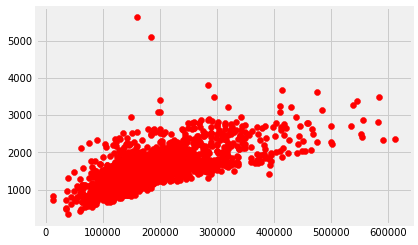

In [13]:
plt.scatter(ames_train['SalePrice'], ames_train['Gr Liv Area'],color='red')

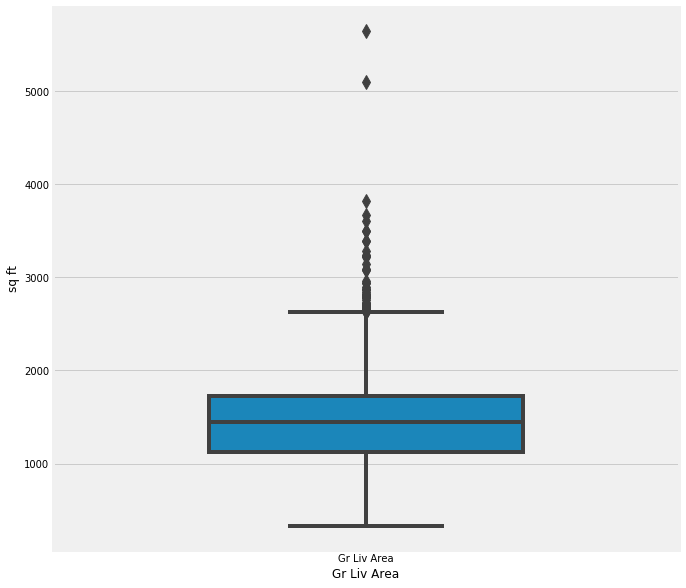

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.boxplot(data = ames_train, order = ['Gr Liv Area'], 
                 orient = 'v', width = 0.5, fliersize = 10).set(
    xlabel='Gr Liv Area', ylabel='sq ft')

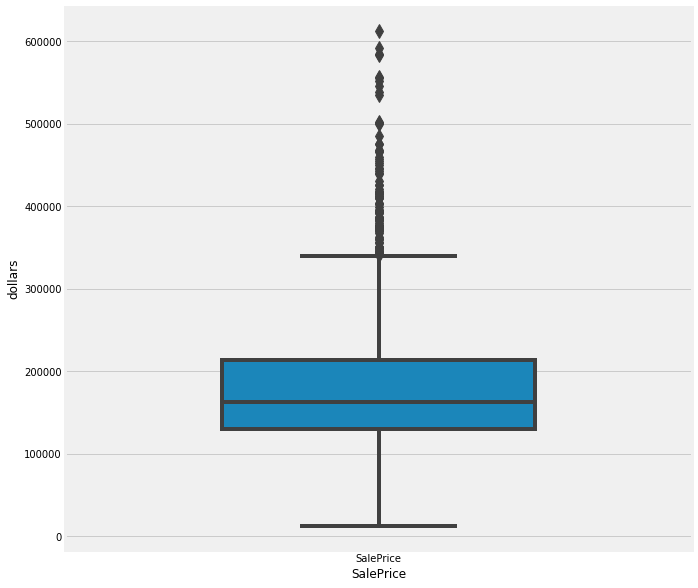

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.boxplot(data = ames_train, order = ['SalePrice'], 
                 orient = 'v', width = 0.5, fliersize = 10).set(
    xlabel='SalePrice', ylabel='dollars')

In [16]:
ss = StandardScaler()

In [17]:
#Split df so that dummy variables are not standardized
ames1=ames_train.iloc[:,0:7]
ames2=ames_train.iloc[:,8:]

In [18]:
#Standarizing all other columns
ames1s = ss.fit_transform(ames1)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [19]:
#convert them back to DataFrames
ames1s=pd.DataFrame(ames1s, columns = ames_train.iloc[:,0:7].columns)
ames2=pd.DataFrame(ames2, columns = ames_train.iloc[:,8:].columns)

In [20]:
#combine them back
ames_train_s = pd.concat([ames1s,ames2], axis=1,sort=False)

In [21]:
X = ames_train_s
y = ames_train.SalePrice

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20 , train_size=0.7 , test_size=0.3)

linreg = LinearRegression()
model = linreg.fit(X_train,y_train)
linreg_scores = cross_val_score(model, X, y, cv=10)

print (linreg_scores)
print (np.mean(linreg_scores))

[ 8.36374546e-01  8.53112794e-01 -2.58954629e+24  8.80485239e-01
  7.10158337e-01  8.47369155e-01  8.66610127e-01  8.38371384e-01
  8.12103211e-01  7.59388811e-01]
-2.589546290787218e+23


In [23]:
#Try Lasso

optimal_lasso = LassoCV(n_alphas=1000, cv=10, verbose=1)
optimal_lasso.fit(X_train, y_train)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

62.65401622935269


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [24]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, X, y, cv=10)

print (lasso_scores)
print (np.mean(lasso_scores))
#slightly worst off than baseline

[0.82850517 0.85573831 0.83298221 0.87977995 0.70493885 0.85200021
 0.86562148 0.8401431  0.81873785 0.75762172]
0.8236068833900598


In [25]:
lasso.fit(X_train, y_train)

Lasso(alpha=62.65401622935269, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [26]:
lasso_coefs = pd.DataFrame({'variable':X_train.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)

,variable,coef,abs_coef
52,Neighborhood_StoneBr,63355.679078,63355.679078
46,Neighborhood_NridgHt,56058.913005,56058.913005
37,Neighborhood_GrnHill,55226.527908,55226.527908
19,MS SubClass_160,-41184.428354,41184.428354
45,Neighborhood_NoRidge,30088.553678,30088.553678
5,Gr Liv Area,27515.992107,27515.992107
2,Overall Qual,26865.187007,26865.187007
17,MS SubClass_120,-25059.256669,25059.256669
33,Neighborhood_Crawfor,22857.267366,22857.267366
4,Year Built,22633.648529,22633.648529


In [27]:
print(lasso_coefs.shape)
print(np.sum((lasso.coef_ == 0)))                                                          
print('Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(lasso_coefs.shape[0]))
#okay, too many variables. Need to scale down

(55, 3)
17
Percent variables zeroed out: 0.3090909090909091


In [28]:
lasso_coefs2 = lasso_coefs[:(55-17)]
lasso_coefs2 = lasso_coefs2.drop(['coef','abs_coef'], axis=1)
lasso_coefs2

,variable
52,Neighborhood_StoneBr
46,Neighborhood_NridgHt
37,Neighborhood_GrnHill
19,MS SubClass_160
45,Neighborhood_NoRidge
5,Gr Liv Area
2,Overall Qual
17,MS SubClass_120
33,Neighborhood_Crawfor
4,Year Built


In [67]:
#drop [''Neighborhood_GrnHill', 'MS SubClass_30'] because
#they are not in this test set

X2 = X[[
    "Neighborhood_StoneBr",
"Neighborhood_NridgHt",
"MS SubClass_160",
"Neighborhood_NoRidge",
"Gr Liv Area",
"Overall Qual",
"MS SubClass_120",
"Neighborhood_Crawfor",
"Year Built",
"MS SubClass_90",
"MS SubClass_60",
"Neighborhood_Edwards",
"Neighborhood_Gilbert",
"Neighborhood_SawyerW",
"Neighborhood_Timber",
"MS SubClass_70",
"Neighborhood_NWAmes",
"MS SubClass_80",
"MS Zoning_FV",
"MS SubClass_190",
"Neighborhood_Veenker",
"Overall Cond",
"Lot Area",
"Neighborhood_ClearCr",
"Neighborhood_SWISU",
"Neighborhood_CollgCr",
"Neighborhood_IDOTRR",
"MS Zoning_RM",
"MS SubClass_50",
"Neighborhood_Somerst",
"Neighborhood_Sawyer",
"Neighborhood_NAmes",
"MS SubClass_85",
"Utilities",
"Neighborhood_OldTown",
"Garage Qual"]]

In [68]:
X2
y = ames_train.SalePrice

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, random_state=20 , train_size=0.7 , test_size=0.3)

linreg = LinearRegression()
model2 = linreg.fit(X_train2,y_train2)
linreg_scores2 = cross_val_score(model2, X2, y, cv=10)

print (linreg_scores2)
print (np.mean(linreg_scores2))

[0.83199398 0.85449658 0.83376175 0.87843534 0.71161942 0.85183564
 0.86442517 0.83596819 0.81806478 0.76387043]
0.8244471285955575


In [69]:
#Try Lasso

optimal_lasso = LassoCV(n_alphas=1000, cv=10, verbose=1)
optimal_lasso.fit(X_train2, y_train2)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

62.654016229352756


......................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s finished


In [70]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, X, y, cv=10)

print (lasso_scores)
print (np.mean(lasso_scores))
#slightly better than benchmark

[0.82850517 0.85573831 0.83298221 0.87977995 0.70493885 0.85200021
 0.86562148 0.8401431  0.81873785 0.75762172]
0.8236068833900598


In [71]:
lasso_model = lasso.fit(X_train2, y_train2)
lasso_model

Lasso(alpha=62.654016229352756, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [72]:
lasso_coefs = pd.DataFrame({'variable':X_train2.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head()

,variable,coef,abs_coef
0,Neighborhood_StoneBr,62628.734678,62628.734678
1,Neighborhood_NridgHt,55881.863468,55881.863468
2,MS SubClass_160,-42173.095888,42173.095888
3,Neighborhood_NoRidge,30010.684518,30010.684518
4,Gr Liv Area,27195.083035,27195.083035


In [73]:
print(lasso_coefs.shape)
print(np.sum((lasso.coef_ == 0)))                                                          
print('Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(lasso_coefs.shape[0]))
#okay, too many variables. Need to scale down

(36, 3)
0
Percent variables zeroed out: 0.0


In [74]:
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train2, y_train2)

print(optimal_ridge.alpha_)

1.0


In [75]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, X, y, cv=10)

print (ridge_scores)
print (np.mean(ridge_scores))

[0.83405813 0.8549833  0.84177701 0.88079282 0.70816736 0.85200832
 0.86764783 0.83952747 0.81536294 0.75854761]
0.8252872790571578


In [76]:
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10,
                            verbose=1)
optimal_enet.fit(X_train2, y_train2)

print (optimal_enet.alpha_)
print (optimal_enet.l1_ratio_)
#Full lasso model is preferred

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

62.654016229352756
1.0


..............................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    4.5s finished


In [77]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, X, y, cv=10)

print (enet_scores)
print (np.mean(enet_scores))
#same as lasso score

[0.82850517 0.85573831 0.83298221 0.87977995 0.70493885 0.85200021
 0.86562148 0.8401431  0.81873785 0.75762172]
0.8236068833900598


In [78]:
lasso_model = lasso.fit(X_train2, y_train2)

In [79]:
lasso_model.score(X_train2, y_train2)

0.8226308718298132

In [80]:
lasso_model.score(X_test2, y_test2)

0.854007114152983

In [81]:
lasso_scores.mean()

0.8236068833900598

In [82]:
y_pred = lasso_model.predict(X_test2)

In [83]:
r2_score(y_test2, y_pred)

0.854007114152983

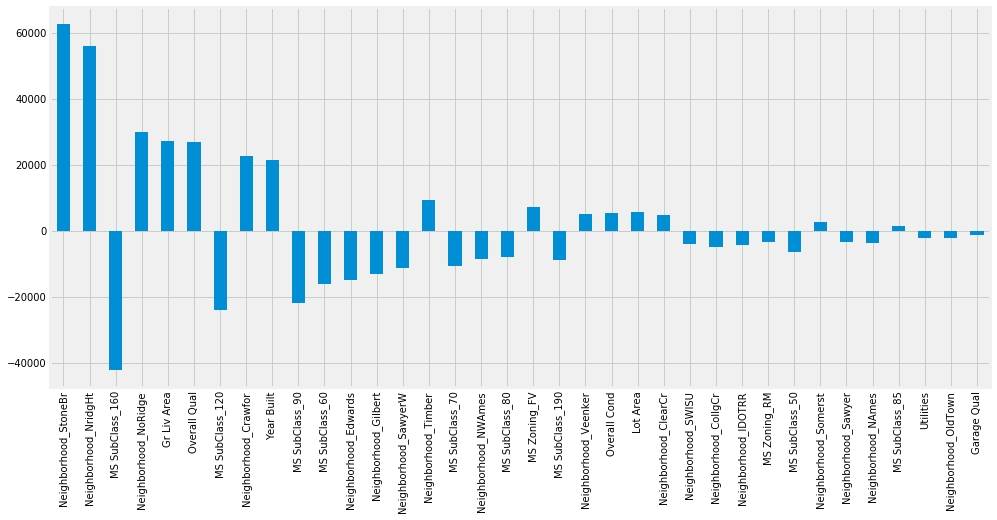

In [84]:
pd.Series(lasso.coef_, index=X2.columns).plot.bar(figsize=(15, 7))

In [85]:
residuals = y_test - y_pred

In [86]:
lasso_mse = mean_squared_error(y_test, y_pred)
lasso_rmse = np.sqrt(lasso_mse)

print(lasso_mse)
print(lasso_rmse)

964441360.010908
31055.456203554764


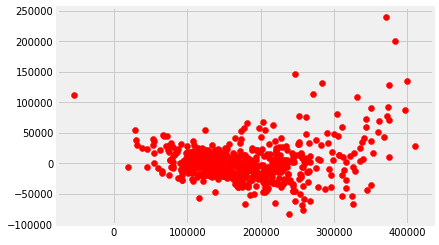

In [87]:
plt.scatter(y_pred, residuals,color='red')

In [88]:
ames_test = pd.read_csv('datasets/test.csv')

In [51]:
explore(ames_test)

(879, 80)

     Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0  2658  902301120          190        RM          69.0      9142   Pave   
1  2718  905108090           90        RL           NaN      9662   Pave   
2  2414  528218130           60        RL          58.0     17104   Pave   
3  1989  902207150           30        RM          60.0      8520   Pave   
4   625  535105100           20        RL           NaN      9500   Pave   

  Alley Lot Shape Land Contour Utilities Lot Config Land Slope Neighborhood  \
0  Grvl       Reg          Lvl    AllPub     Inside        Gtl      OldTown   
1   NaN       IR1          Lvl    AllPub     Inside        Gtl       Sawyer   
2   NaN       IR1          Lvl    AllPub     Inside        Gtl      Gilbert   
3   NaN       Reg          Lvl    AllPub     Inside        Gtl      OldTown   
4   NaN       IR1          Lvl    AllPub     Inside        Gtl        NAmes   

  Condition 1 Condition 2 Bldg Type House Style  Overall 

In [52]:
ames_test.loc[(ames_test['Pool QC'].isin([np.nan]))]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,6,8,1910,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,Fa,Stone,Fa,TA,No,Unf,0,Unf,0,1020,1020,GasA,Gd,N,FuseP,908,1020,0,1928,0,0,2,0,4,2,Fa,9,Typ,0,NaN,Detchd,1910.0,Unf,1,440,Po,Po,Y,0,60,112,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,5,4,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,1967,1967,GasA,TA,Y,SBrkr,1967,0,0,1967,0,0,2,0,6,2,TA,10,Typ,0,NaN,Attchd,1977.0,Fin,2,580,TA,TA,Y,170,0,0,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,Gd,Av,GLQ,554,Unf,0,100,654,GasA,Ex,Y,SBrkr,664,832,0,1496,1,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2006.0,RFn,2,426,TA,TA,Y,100,24,0,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,5,6,1923,2006,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Gd,TA,CBlock,TA,TA,No,Unf,0,Unf,0,968,968,GasA,TA,Y,SBrkr,968,0,0,968,0,0,1,0,2,1,TA,5,Typ,0,NaN,Detchd,1935.0,Unf,2,480,Fa,TA,N,0,0,184,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1963,1963,Gable,CompShg,Plywood,Plywood,BrkFace,247.0,TA,TA,CBlock,Gd,TA,No,BLQ,609,Unf,0,785,1394,GasA,Gd,Y,SBrkr,1394,0,0,1394,1,0,1,1,3,1,TA,6,Typ,2,Gd,Attchd,1963.0,RFn,2,514,TA,TA,Y,0,76,0,0,185,0,NaN,NaN,NaN,0,7,2009,WD
5,333,923228370,160,RM,21.0,1890,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,6,1972,1972,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,294,Unf,0,252,546,GasA,TA,Y,SBrkr,546,546,0,1092,0,0,1,1,3,1,TA,5,Typ,0,NaN,Attchd,1972.0,Unf,1,286,TA,TA,Y,0,0,64,0,0,0,NaN,NaN,NaN,0,6,2010,WD
6,1327,902427150,20,RM,52.0,8516,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,4,6,1958,2006,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,869,869,GasA,TA,Y,SBrkr,1093,0,0,1093,0,0,1,0,2,1,TA,5,Typ,0,NaN,Detchd,1959.0,Unf,1,308,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD
7,858,907202130,20,RL,NaN,9286,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Mod,CollgCr,Norm,Norm,1Fam,1Story,5,7,1977,1989,Gable,CompShg,HdBoard,Plywood,None,0.0,TA,TA,CBlock,Gd,Gd,Av,ALQ,196,Unf,0,1072,1268,GasA,TA,Y,SBrkr,1268,0,0,1268,0,0,1,1,3,1,Gd,5,Typ,0,NaN,Detchd,1978.0,Unf,1,252,TA,TA,Y,173,0,0,0,0,0,NaN,NaN,NaN,0,10,2009,WD
8,95,533208090,160,FV,39.0,3515,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,TwnhsE,2Story,7,5,2004,2004,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,840,840,GasA,Ex,Y,SBrkr,840,840,0,1680,0,0,2,1,2,1,Gd,3,Typ,0,NaN,Attchd,2004.0,RFn,2,588,TA,TA,Y,0,111,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD
9,1568,914476010,20,RL,75.0,10125,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,6,6,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,N

In [53]:
#Replacing the np.nan cells to their respective column values

#changing to 0 for no lot frontage, 160 entries
ames_test['Lot Frontage'] = ames_test['Lot Frontage'].replace({np.nan:0})
#Changing to NA for no alley access
ames_test['Alley'] = ames_test['Alley'].replace({np.nan:'NA'})

#both 'Mas Vnr Type' and 'Mas Vnr Area' are 1 entry that are tied to each other
ames_test['Mas Vnr Type'] = ames_test['Mas Vnr Type'].replace({np.nan:'None'})
ames_test['Mas Vnr Area'] = ames_test['Mas Vnr Area'].replace({np.nan:0})

#25 entries without basement
ames_test['Bsmt Qual'] = ames_test['Bsmt Qual'].replace({np.nan:'NA'})
ames_test['Bsmt Cond'] = ames_test['Bsmt Cond'].replace({np.nan:'NA'})
ames_test['Bsmt Exposure'] = ames_test['Bsmt Exposure'].replace({np.nan:'NA'})
ames_test['BsmtFin Type 1'] = ames_test['BsmtFin Type 1'].replace({np.nan:'NA'})
ames_test['BsmtFin Type 2'] = ames_test['BsmtFin Type 2'].replace({np.nan:'NA'})

#1 electrical entry without additional information
ames_test.iloc[635, ames_test.columns.get_loc('Electrical')] = 'Mixed'

#All fireplace Qu with np.nan is does not have a fireplace,422 entries
ames_test['Fireplace Qu'] = ames_test['Fireplace Qu'].replace({np.nan:'NA'})

#All except for row765, does not have a garage. 44 entries without garage
ames_test['Garage Type'] = ames_test['Garage Type'].replace({np.nan:'NA'})
ames_test.iloc[765, ames_test.columns.get_loc('Garage Yr Blt')] = ames_test.iloc[765, ames_test.columns.get_loc('Year Remod/Add')]
ames_test['Garage Yr Blt'] = ames_test['Garage Yr Blt'].replace({np.nan:0})
ames_test['Garage Finish'] = ames_test['Garage Finish'].replace({np.nan:'NA'})
ames_test['Garage Qual'] = ames_test['Garage Qual'].replace({np.nan:'NA'})
ames_test['Garage Cond'] = ames_test['Garage Cond'].replace({np.nan:'NA'})


#All Pool QC with np.nan has pool area of 0
ames_test['Pool QC'] = ames_test['Pool QC'].replace({np.nan:'NA'})
ames_test['Fence'] = ames_test['Fence'].replace({np.nan:'NA'})
ames_test['Misc Feature'] = ames_test['Misc Feature'].replace({np.nan:'NA'})

In [55]:
ames_test=ames_test[['MS SubClass',
                       'MS Zoning',
                       'Lot Area',
                       'Utilities',
                       'Neighborhood',
                      'Overall Qual',
                      'Overall Cond',
                      'Year Built',
                      'Gr Liv Area',
                      'Garage Qual',]]

In [56]:
def transform2(col):
    for i in col:
        le.fit(ames_test[i])
        list(le.classes_)
        ames_test[i] = le.transform(ames_test[i])

transform2(columns)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [57]:
ames_test = pd.get_dummies(data = ames_test, prefix=column2, columns = column2, drop_first=True)

In [59]:
ames1_test=ames_test.iloc[:,0:7]
ames2_test=ames_test.iloc[:,8:]

In [60]:
ames1_test.head()

,Lot Area,Utilities,Overall Qual,Overall Cond,Year Built,Gr Liv Area,Garage Qual
0,9142,0,6,8,1910,1928,3
1,9662,0,5,4,1977,1967,4
2,17104,0,7,5,2006,1496,4
3,8520,0,5,6,1923,968,0
4,9500,0,6,5,1963,1394,4


In [61]:
#Standarizing all other columns
ames1s_test = ss.fit_transform(ames1_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [62]:
#convert them back to DataFrames
ames1s_test=pd.DataFrame(ames1s_test, columns = ames_test.iloc[:,0:7].columns)
ames2_test=pd.DataFrame(ames2_test, columns = ames_test.iloc[:,8:].columns)

In [63]:
#combine them back
ames_test_s = pd.concat([ames1s_test,ames2_test], axis=1,sort=False)

In [89]:
#drop [''Neighborhood_GrnHill', 'MS SubClass_30'] because
#they are not in this test set
X_test_final = ames_test_s[[ 
"Neighborhood_StoneBr",
"Neighborhood_NridgHt",
"MS SubClass_160",
"Neighborhood_NoRidge",
"Gr Liv Area",
"Overall Qual",
"MS SubClass_120",
"Neighborhood_Crawfor",
"Year Built",
"MS SubClass_90",
"MS SubClass_60",
"Neighborhood_Edwards",
"Neighborhood_Gilbert",
"Neighborhood_SawyerW",
"Neighborhood_Timber",
"MS SubClass_70",
"Neighborhood_NWAmes",
"MS SubClass_80",
"MS Zoning_FV",
"MS SubClass_190",
"Neighborhood_Veenker",
"Overall Cond",
"Lot Area",
"Neighborhood_ClearCr",
"Neighborhood_SWISU",
"Neighborhood_CollgCr",
"Neighborhood_IDOTRR",
"MS Zoning_RM",
"MS SubClass_50",
"Neighborhood_Somerst",
"Neighborhood_Sawyer",
"Neighborhood_NAmes",
"MS SubClass_85",
"Utilities",
"Neighborhood_OldTown",
"Garage Qual"]]

In [90]:
y_pred_test = lasso_model.predict(X_test_final)

In [91]:
#y_pred_test
#ames_test
#ames1s_test = pd.DataFrame(ames1s_test, columns = ames_test.iloc[:,0:58].columns)
y_pred_test=pd.DataFrame(y_pred_test, columns = ['SalePrice'])
final = pd.concat([ames_test.iloc[:,0],y_pred_test], axis=1)

In [92]:
final = final.sort_values(by=['Id'],ascending=True)
final

,Id,SalePrice
704,2,127575.247209
706,4,230603.878799
120,6,184008.827335
312,7,271589.414355
401,17,240146.760469
316,18,338052.295767
791,22,186620.722246
608,27,106787.403000
391,31,92224.216880
753,36,139857.186292


In [93]:
final.to_csv("datasets/final3.csv", index=False) 